In [40]:
from enum import Enum
from functools import reduce
from PIL import Image

In [41]:
class CardinalDirection(Enum):
    UP = 0
    LEFT = 1
    DOWN = 2
    RIGHT = 3


class GridObject:
    def __init__(self, position: tuple[int, int], occupiable: bool):
        self.position = position
        self.is_occupiable = occupiable

    def __repr__(self):
        return f'{self.__class__.__name__}({self.position})'


class EmptySquare(GridObject):
    def __init__(self, x, y):
        super().__init__((x, y), occupiable=True)


class Wall(GridObject):
    def __init__(self, x, y):
        super().__init__((x, y), occupiable=False)


class Actor(GridObject):
    class Rotation(Enum):
        CLOCKWISE = -1
        COUNTERCLOCKWISE = 1

    DIRECTIONS = (CardinalDirection.RIGHT, CardinalDirection.UP, CardinalDirection.LEFT, CardinalDirection.DOWN)

    @staticmethod
    def rotate_direction(direction: CardinalDirection, rotation: Rotation):
        return Actor.DIRECTIONS[(rotation.value + Actor.DIRECTIONS.index(direction)) % len(Actor.DIRECTIONS)]

    def __init__(self, x: int, y: int):
        super().__init__((x, y), occupiable=False)
        # Instructions say to start heading East
        self.direction = CardinalDirection.RIGHT
        self.score = 0
        self.previous: list[tuple[int,int]] = []

    def rotate(self, rotation: Rotation):
        self.direction = Actor.rotate_direction(self.direction, rotation)

    @classmethod
    def from_actor(cls, actor: 'Actor'):
        clone = cls(*actor.position)
        clone.direction = actor.direction
        clone.is_occupiable = actor.is_occupiable
        clone.score = actor.score
        clone.previous.extend(actor.previous)
        return clone


class Grid:
    MOVEMENT = {
        CardinalDirection.UP: lambda x, y: (x, y - 1),
        CardinalDirection.DOWN: lambda x, y: (x, y + 1),
        CardinalDirection.LEFT: lambda x, y: (x - 1, y),
        CardinalDirection.RIGHT: lambda x, y: (x + 1, y),
    }

    class Points:
        class MoveType:
            ANGULAR = 1000
            LINEAR = 1

    @staticmethod
    def next_position(direction: CardinalDirection, position: tuple[int, int]):
        return Grid.MOVEMENT[direction](*position)

    def can_move(self, position: tuple[int, int]):
        grid_object = self.index.get(position)
        if not grid_object:
            return False
        elif isinstance(grid_object, EmptySquare):
            return True
        return False

    def __init__(self, debug=False):
        self.debug = debug
        self.start = EmptySquare(0, 0)
        self.end = EmptySquare(0, 0)
        self.index: dict[tuple[int, int], GridObject] = {}
        self.width = 0
        self.height = 0
        self.data = []

    def load_input(self):
        with open("../../data/day16-input.txt") as f:
            for y, line in enumerate(f.readlines()):
                row = []
                for x, c in enumerate(line.strip()):
                    if c == '#':
                        item = Wall(x, y)
                    elif c == 'S':
                        item = self.start
                        self.start.position = x, y
                    elif c == 'E':
                        item = self.end
                        self.end.position = x, y
                    elif c == '.':
                        item = EmptySquare(x, y)
                    else:
                        raise ValueError("Unhandled: " + c)
                    row.append(item)
                    self.index[(x, y)] = item
                self.data.append(row)

            self.width = len(self.data[0])
            self.height = len(self.data)
        return self

    def start_walking(self, max_iteration: int = None):
        current_score = 2 ** 63 - 1
        winning_actors = []
        actors = [Actor(*self.start.position)]

        square_score_index: dict[tuple[int, int], int] = {}
        for x in range(len(self.data[0])):
            for y in range(len(self.data)):
                square_score_index[(x, y)] = 2 ** 63 - 1

        max_iteration = max_iteration if max_iteration is not None else 10e10
        iteration = 0

        while actors and iteration < max_iteration:
            iteration += 1
            for _ in range(len(actors)):
                actor = actors.pop(0)
                if actor.position == self.end.position:
                    actor.previous.append(actor.position)
                    if actor.score <= current_score:
                        winning_actors.append(actor)
                        current_score = actor.score
                else:
                    walks = self.walk_actor(actor)
                    for actor in walks:
                        if actor.score <= square_score_index[actor.position]:
                            actors.append(actor)
                            square_score_index[actor.position] = actor.score
            if self.debug:
                img_name = iteration % 3000
                self.visualize(actors).save(f'../../data/day16/{img_name:06}.png')

        return winning_actors, iteration

    def walk_actor(self, actor: Actor) -> list[Actor, ...]:
        """
        As you're walking, you'd never turn back the opposite direction.
        Assume walking in the current direction. If you encounter additional
        routes, then clone yourself and go down those routes.
        However, when rotating, we need to be sure we check all directions
        before dropping this agent.

        :param position:
        :param direction:
        :param current_score:
        :return:
        """
        actors = []
        next_position = Grid.next_position(actor.direction, actor.position)
        direction = actor.direction
        peek_left = Grid.next_position(Actor.rotate_direction(direction, Actor.Rotation.COUNTERCLOCKWISE),
                                       actor.position)
        peek_right = Grid.next_position(Actor.rotate_direction(direction, Actor.Rotation.CLOCKWISE), actor.position)

        if self.can_move(peek_left):
            clone = Actor.from_actor(actor)
            clone.rotate(Actor.Rotation.COUNTERCLOCKWISE)
            clone.score += Grid.Points.MoveType.ANGULAR
            clone.previous.append(clone.position)
            clone.position = peek_left
            clone.score += Grid.Points.MoveType.LINEAR
            actors.append(clone)

        if self.can_move(peek_right):
            clone = Actor.from_actor(actor)
            clone.rotate(Actor.Rotation.CLOCKWISE)
            clone.score += Grid.Points.MoveType.ANGULAR
            clone.previous.append(clone.position)
            clone.position = peek_right
            clone.score += Grid.Points.MoveType.LINEAR
            actors.append(clone)

        if self.can_move(next_position):
            actor.previous.append(actor.position)
            actor.position = next_position
            actor.score += Grid.Points.MoveType.LINEAR
            actors.append(actor)
        return actors

    def visualize(self, actors: list[Actor], scale=5):
        img = Image.new('RGB', (scale * self.width, scale * self.height), 'white')
        pixels = img.load()

        for x in range(self.width):
            for y in range(self.height):
                item = self.index[(x, y)]
                if isinstance(item, Wall):
                    for sx in range(scale):
                        for sy in range(scale):
                            pixels[scale * x + sx, scale * y + sy] = (0, 0, 0)

        if actors:
            for actor in actors:
                x, y = actor.position
                for sx in range(scale):
                    for sy in range(scale):
                        pixels[scale * x + sx, scale * y + sy] = (255, 0, 0)
        return img


grid = Grid().load_input()
winning_actors, iteration = grid.start_walking(max_iteration=None)

# Get the actors that are 1st place.
winning_actors = sorted(winning_actors, key=lambda actor: actor.score, reverse=False)
winning_actors = [a for a in winning_actors if a.score == winning_actors[0].score]

print("Winning Actor's score:", winning_actors[0].score)

Winning Actor's score: 105496


### Part 2


In [42]:
def visualize_actor_paths(grid: Grid, actors: list[Actor], scale=7):
    img = Image.new('RGB', (scale * grid.width, scale * grid.height), 'white')
    pixels = img.load()

    for x in range(grid.width):
        for y in range(grid.height):
            item = grid.index[(x, y)]
            if isinstance(item, Wall):
                for sx in range(scale):
                    for sy in range(scale):
                        pixels[scale * x + sx, scale * y + sy] = (0, 0, 0)

    if actors:
        for id, actor in enumerate(actors):
            delta = 255 // len(actors)
            color = (id*delta % 255, (35 + id*delta) % 255, -id*delta % 255 )
            for position in actor.previous:
                x, y = position
                for sx in range(scale):
                    for sy in range(scale):
                        pixels[scale * x + sx, scale * y + sy] = color
    return img

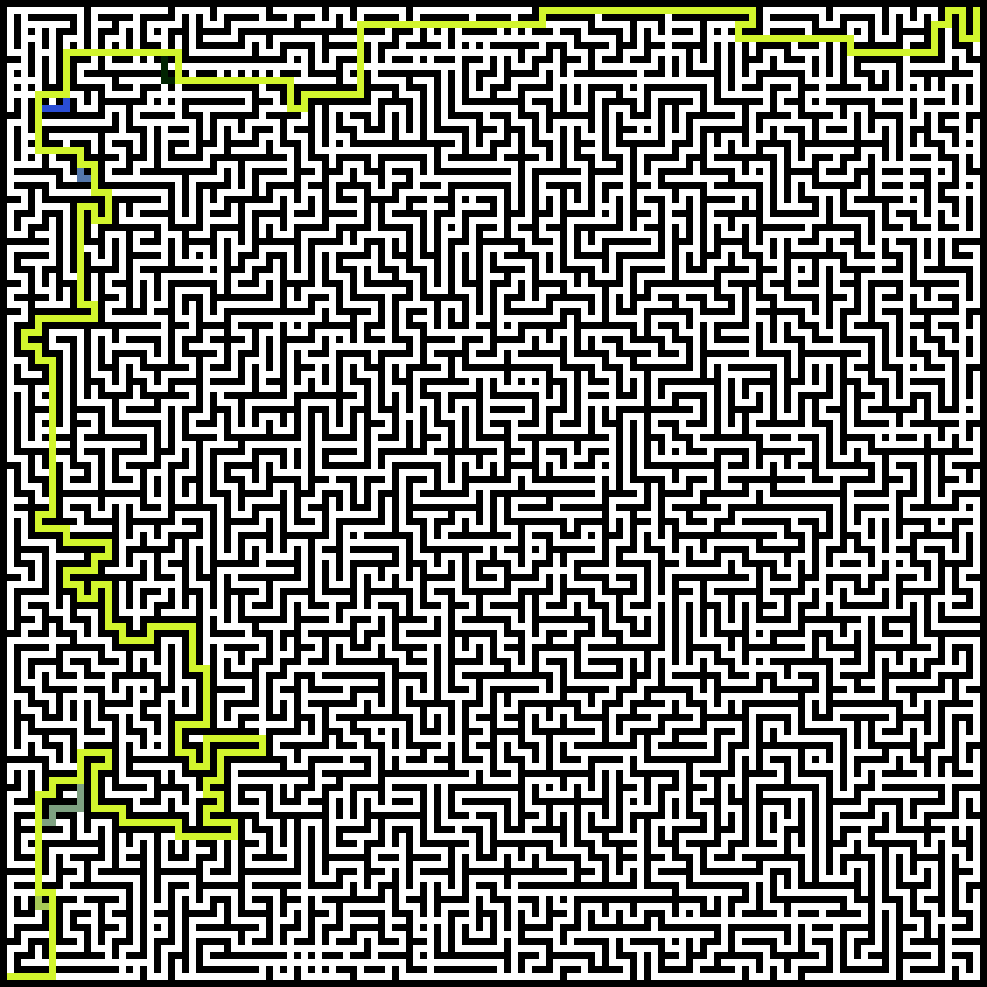

In [43]:
visualize_actor_paths(grid, winning_actors)

In [44]:
count_of_squares = len(reduce(lambda s1, s2: s1 | s2, map(lambda a: set(a.previous), winning_actors), set()))
print("The total squares traveled by the winners is", count_of_squares)

The total squares traveled by the winners is 524
